# Notebook 1: SHAP — Explaining a Loan/Income Prediction Model

## What we are doing
We have a **model that predicts whether a person's income is above or below $50,000** (using Census data). In practice, such models are used for lending, hiring, or eligibility decisions. Without explanation, we cannot know **why** the model said "high income" or "low income," or whether it is **biased** or relying on sensible features.

## Why it matters
**Explainability** helps us:
- **Trust** the model (or reject it) by seeing which features drive predictions.
- **Debug** bias (e.g., if "race" or "sex" have undue influence).
- **Comply** with regulations that require reasons for automated decisions.

In this notebook we use **SHAP (SHapley Additive exPlanations)** — a method from **game theory** — to attribute each prediction to the input features. We will see both a **global** view (which features matter overall) and a **local** view (why one specific person was predicted "high income").

In [3]:
# Setup: Install dependencies (run once; then you can comment out)
# !pip install shap xgboost matplotlib pandas scikit-learn -q

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Import libraries
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import matplotlib.pyplot as plt

# Load Census Income dataset (built-in with SHAP — no manual download)
X, y = shap.datasets.adult()
print("Dataset shape:", X.shape)
print("Target: 1 = Income > $50K, 0 = Income ≤ $50K")
X.head()

Dataset shape: (32561, 12)
Target: 1 = Income > $50K, 0 = Income ≤ $50K


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


In [5]:
# Encode categorical columns so the model can use them
X_encoded = X.copy()
label_encoders = {}
for col in X_encoded.select_dtypes(include=["object"]).columns:
    le = LabelEncoder()
    X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    label_encoders[col] = le

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Train XGBoost classifier (target: income > 50k)
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
)
model.fit(X_train, y_train)

# Quick accuracy check
train_acc = model.score(X_train, y_train)
test_acc = model.score(X_test, y_test)
print(f"Train accuracy: {train_acc:.3f}  |  Test accuracy: {test_acc:.3f}")

Train accuracy: 0.886  |  Test accuracy: 0.877


---
## The "Black Box": A prediction without explanation

We can ask the model: *"Does this person earn more than $50k?"* and get a yes/no (or probability). Without XAI, we have **no idea why** it said that.

In [24]:
# Pick one person from the test set (we will explain this person later)
sample_idx = 1
one_person = X_test.iloc[sample_idx : sample_idx + 1]
pred_proba = model.predict_proba(one_person)[0]
pred_label = model.predict(one_person)[0]

print("Black-box prediction for one individual:")
print(f"  Predicted probability of Income > $50K: {pred_proba[1]:.3f}")
print(f"  Predicted class: {'Income > $50K' if pred_label == 1 else 'Income ≤ $50K'}")
print("\nWe have no idea WHY the model said this — yet.")

Black-box prediction for one individual:
  Predicted probability of Income > $50K: 0.327
  Predicted class: Income ≤ $50K

We have no idea WHY the model said this — yet.


---
## The "Why": SHAP explanations

We use **SHAP** to see how much each feature **pushes** the prediction up or down compared to the average. We'll look at:
1. **Global view** — which features matter most across many people (beeswarm).
2. **Local view** — why one specific person got their prediction (force plot).

In [9]:
# Create SHAP TreeExplainer (efficient for tree models) on a sample for speed
sample_size = 500
X_sample = X_test.sample(n=min(sample_size, len(X_test)), random_state=42)

explainer = shap.TreeExplainer(model, X_sample)
# SHAP values: how much each feature pushes prediction toward 1 (high income) or 0 (low income)
shap_values = explainer.shap_values(X_sample)
# For binary classification, XGBoost may return a list; we use the positive class
if isinstance(shap_values, list):
    shap_values = shap_values[1]

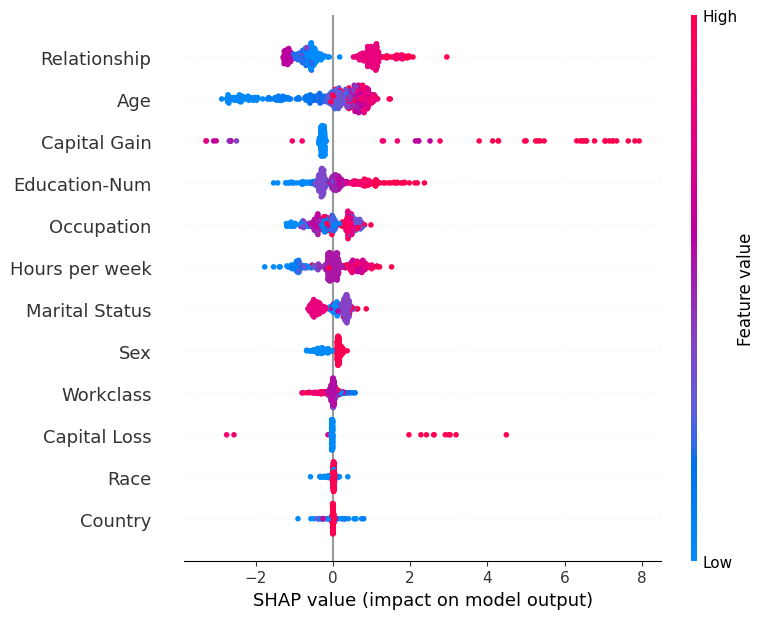

In [10]:
# Global view: SHAP Beeswarm Plot
# Each dot = one person. Vertical axis = feature, horizontal = SHAP value (impact on prediction).
# Color = feature value (red = high, blue = low) for that person.
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.tight_layout()
plt.show()

### Insight: Reading the Beeswarm Plot

- **Vertical axis:** Features ranked by importance (how much they move the prediction on average). **Age** and **Capital Gain** (and often **Relationship**, **Education**) are typically among the **biggest drivers** of the model.
- **Horizontal axis:** SHAP value. Moving **right** (positive) pushes the prediction toward **Income > $50K**; moving **left** (negative) pushes toward **Income ≤ $50K**.
- **Color:** **Red** = that person has a **high** value for the feature (e.g., high capital gain, older age). **Blue** = **low** value (e.g., low capital gain, younger age).
- So: *"High Capital Gain (red) tends to sit on the right (pushes prediction higher); Low Capital Gain (blue) on the left."* This confirms the model is using economically sensible signals — but we can also check if sensitive attributes (e.g., sex, race) have undue influence.

### Local view: The story of one person

We now explain **why** the model predicted "High Income" (or "Low Income") for **one specific individual** from the test set — the same person we showed in the black-box prediction above.

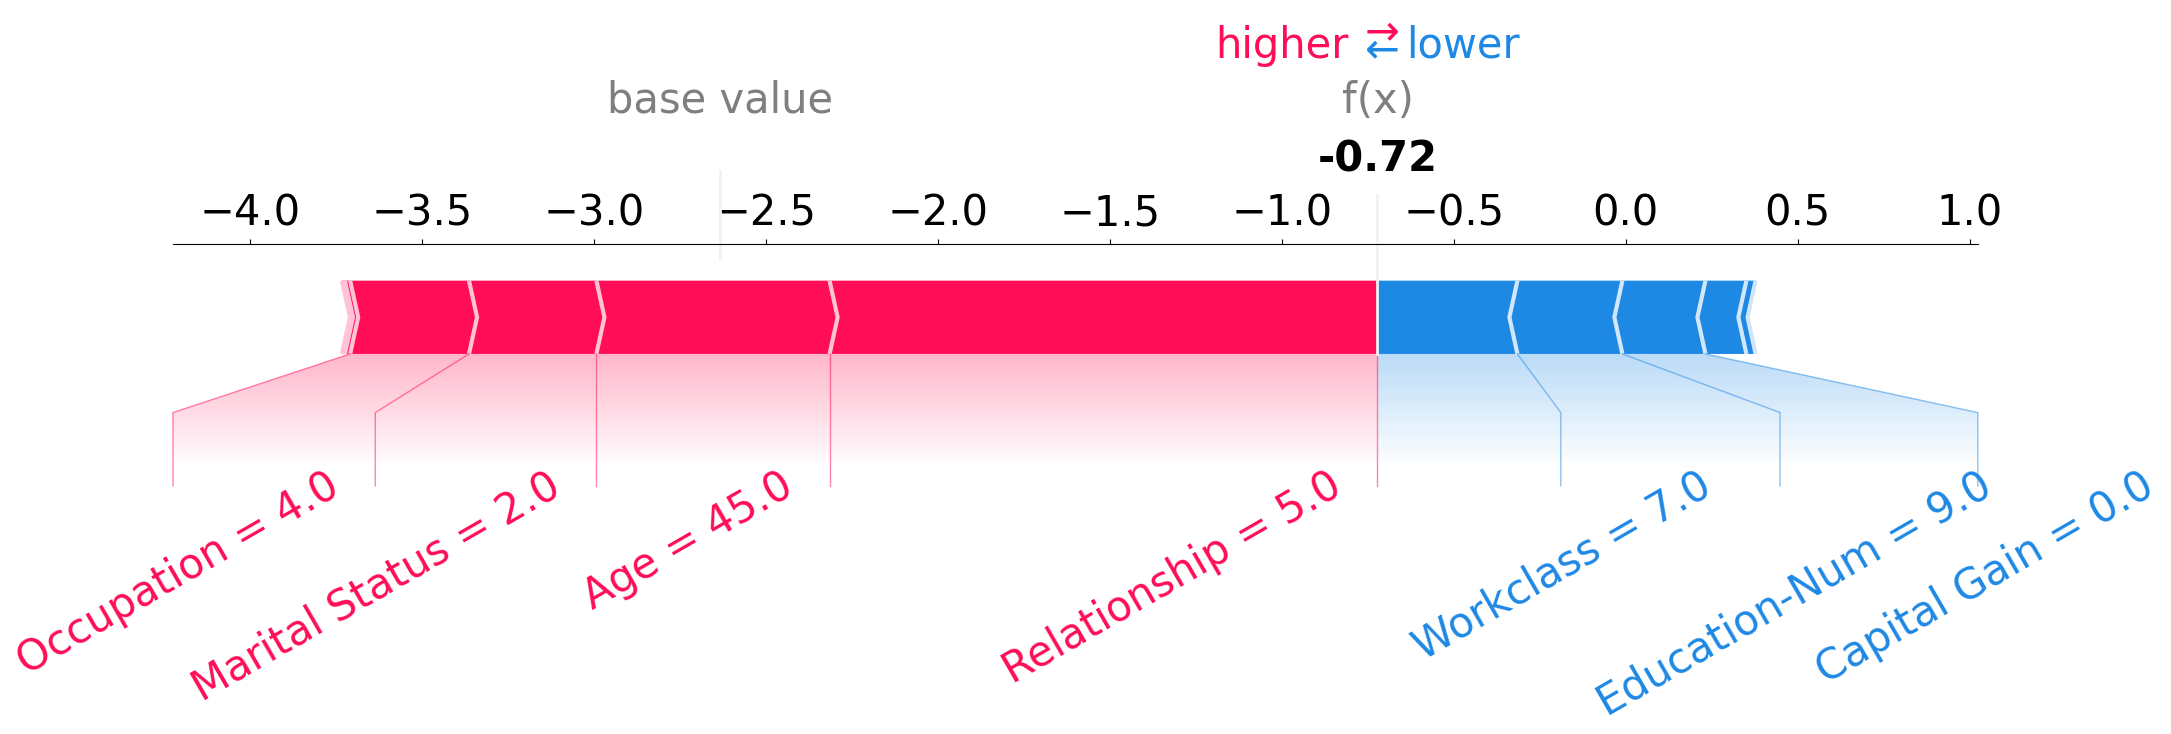

In [25]:
# SHAP values for the single person we chose earlier
one_person_shap = explainer.shap_values(one_person)
if isinstance(one_person_shap, list):
    one_person_shap = one_person_shap[1]
# Base value = average model output (probability scale for XGBoost)
base_val = explainer.expected_value
if isinstance(base_val, np.ndarray):
    base_val = base_val[1]

# Force plot (matplotlib): use plots.force for better control over label overlap
# - Larger figsize gives labels more horizontal space
# - contribution_threshold shows only features above 10% of total |SHAP| (fewer labels)
# - text_rotation=30 prevents labels from overlapping along the bar
shap.plots.force(
    base_val,
    one_person_shap[0],
    one_person.iloc[0].values,
    feature_names=one_person.columns.tolist(),
    matplotlib=True,
    figsize=(22, 8),
    contribution_threshold=0.1,
    text_rotation=30,
    show=False,
)
# Increase font size for all text (SHAP doesn't expose this as a parameter)
for obj in plt.gcf().findobj(lambda x: hasattr(x, 'get_fontsize')):
    try:
        size = obj.get_fontsize()
        obj.set_fontsize(max(size, 30))
    except Exception:
        pass
plt.tight_layout()
plt.show()

### Insight: Reading the Force Plot for this person

The plot shows a **tug-of-war** between features. The **base value** (left) is the model’s average output; the **final prediction** \(f(x)\) is where the red and blue bars meet.

- **Red (positive SHAP):** Features that **push the score UP** (toward higher probability of income >$50k). Here, **Occupation**, **Marital Status**, **Age = 45**, and **Relationship** are the main positive drivers — they shift the prediction to the right from the base value.
- **Blue (negative SHAP):** Features that **push the score DOWN** (toward lower probability of income >$50k). Here, **Workclass**, **Education-Num = 9**, and **Capital Gain = 0** pull the prediction back to the left and partly offset the red bars.
- The **net result** (\(f(x) = -0.72\) in this example) is the baseline plus the sum of all these contributions. So we can say: *"The model’s score is below average for ‘high income’ because, although Occupation, Marital Status, Age, and Relationship push it up, Workclass, lower Education-Num, and zero Capital Gain push it down — and the negative effects win overall."* Reading the force plot this way gives a clear, **per-person** story for **trust** and **debugging** (e.g., checking for unfair use of protected attributes).